I enjoyed reading "A tutorial on the free-energy framework for modelling perception and learning" by *Rafal Bogacz*, which is freely available [here](http://www.sciencedirect.com/science/article/pii/S0022249615000759). In particular, the author encourages to replicate the results in the paper. He is himself giving solutions in matlab, so I had to do the same in python all within a notebook... 

<!-- TEASER_END -->

Let's first initialize the notebook:

In [1]:
from __future__ import division, print_function
import numpy as np
np.set_printoptions(precision=6, suppress=True)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
phi = (np.sqrt(5)+1)/2
fig_width = 10
figsize = (fig_width, fig_width/phi)
do_save = False

# exercise 1 : defining probabilities


First, let's see the application of Bayes theorem 
We start by considering in this section a simple perceptual problem in which a value of a single variable has to be inferred from a single observation. To make it more concrete, consider a simple organism that tries to infer the size or diameter of a food item, which we denote by $v$, on the basis of light intensity it observes. Let us assume that our simple animal has only one light sensitive receptor which provides it with a noisy estimate of light intensity, which we denote by $u$. Let g
 denote a non-linear function relating the average light intensity with the size. Since the amount of light reflected is related to the area of an object, in this example we will consider a simple function of $g(v)=v^2$. Let us further assume that the sensory input is noisy—in particular, when the size of food item is v, the perceived light intensity is normally distributed with mean g(v)
, and variance $Σ_u$ (although a normal distribution is not the best choice for a distribution of light intensity, as it includes negative numbers, we will still use it for a simplicity):
$$
p(u|v)=f(u; g(v), Σ_u),
$$
where $f(x;μ,Σ) $ denotes by definition the density of a normal distribution with mean μ  and variance Σ 

Due to the noise present in the observed light intensity, the animal can refine its guess for the size v
 by combining the sensory stimulus with the prior knowledge on how large the food items usually are, that it had learnt from experience. For simplicity, let us assume that our animal expects this size to be normally distributed with mean $v_p$  and variance $Σ_p$  (subscript p stands for “prior”), which we can write as:
$$
p(v)=f(v; vp, Σ_p).
$$

## Exact solution

To compute how likely different sizes $v$ are given the observed sensory input $u$, we could use Bayes’ theorem:
$$
p(v|u)=p(v)p(u|v)p(u). 
$$

Term $p(u)$  in the denominator of equation is a normalization term, which ensures that the posterior probabilities of all sizes $p(v|u)$  integrate to 1:

$$
p(u)= \int p(v) p(u|v) dv.
$$

The integral in the above equation sums over the whole range of possible values of $v$, so it is a definite integral, but for brevity of notation we do not state the limits of integration in this and all other integrals in the paper.

Now combining Eqs. we can compute numerically how likely different sizes are given the sensory observation. For readers who are not familiar with such Bayesian inference we recommend doing the following exercise now.

### solution to Exercise 1.

Assume that our animal observed the light intensity  $u=2$, the level of noise in its receptor is  $Σ_u=1$, and the mean and variance of its prior expectation of size are  $v_p=3$ and  $Σ_p=1$. Write a computer program that computes the posterior probabilities of sizes from  0.01  to  5, and plots them.

In [2]:
u_obs = 2 # observation
var_u = 1 # noise in the observation
v_p = 3 # prior expectation
var_p = 1 # variance of prior

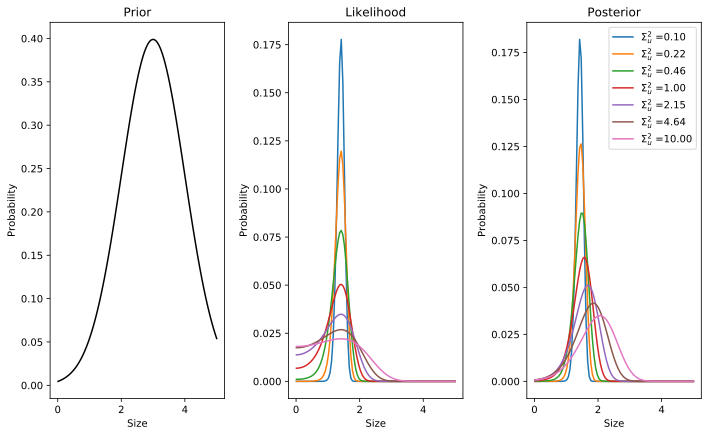

In [3]:
def gauss(x, mean, variance):
    return 1 / np.sqrt(2* np.pi * variance) * np.exp(- .5 * (x - mean)**2 / variance )

g = lambda v: v**2

sizes = np.linspace(0.01, 5, 100)

fig, axs = plt.subplots(1, 3, figsize=figsize)

prior = gauss(sizes, v_p, var_p)
axs[0].plot(sizes, prior, 'k')
axs[0].set_title('Prior')


for var_u_ in np.logspace(-1, 1, 7, base=10)*var_u:
    likelihood = gauss(u_obs, g(sizes), var_u_)
    axs[1].plot(sizes, likelihood/likelihood.sum())
    axs[1].set_title('Likelihood')


    posterior = prior * likelihood
    posterior /= posterior.sum()
    axs[2].plot(sizes, posterior, label=r'$\Sigma_u^2$ ={0:.2f}'.format(var_u_))
    axs[2].set_title('Posterior')

axs[2].legend()
for ax in axs:
    ax.set_xlabel('Size')
    ax.set_ylabel('Probability')

plt.tight_layout()
if do_save == False: fig.savefig('../figures/bogacz_1.png', dpi=600)

# exercise 2 : an online solution

Let's define $F = \log( p(u |v) )$


$$
\frac{\partial F}{\partial v} = \frac{v - v_p}{\Sigma_p} + \dot{g}(v) \cdot \frac{u - g(v)}{\Sigma_u}
$$



In [4]:
dg = lambda v: 2*v

T, dt = 5, 0.01
times = np.linspace(0., T, int(T/dt))

v = np.zeros_like(times)
for i_time, time in enumerate(times):
    if time == 0 :
        v[i_time] = v_p
    else:
        v[i_time] = v[i_time-1] + dt * ( (v[i_time-1] -v_p) / var_p + dg(v[i_time-1]) * (u_obs-g(v[i_time-1] )) / var_u )


# now going online
v = np.zeros_like(times)
eps_u = np.zeros_like(times)
eps_p = np.zeros_like(times)

for i_time, time in enumerate(times):
    if time == 0 :
        v[i_time], eps_u[i_time], eps_p[i_time] = v_p, 0., 0.
    else:
        v[i_time] = v[i_time-1] + dt * ( - eps_p[i_time-1] + dg(v[i_time-1]) * eps_u[i_time-1] )

        eps_p[i_time] = eps_p[i_time-1] + dt * ( (v[i_time] -v_p) - var_p * eps_p[i_time-1] )
        eps_u[i_time] = eps_u[i_time-1] + dt * ( (u_obs-g(v[i_time])) - var_u * eps_u[i_time-1]  )

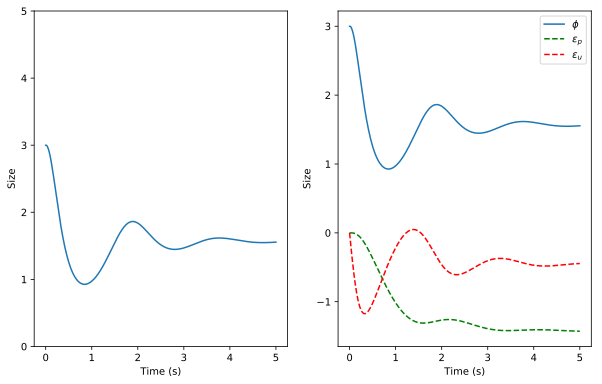

In [5]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=figsize)
ax1.plot(times, v)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Size')
ax1.set_ylim(0, 5)
ax2.plot(times, v, label=r'$\phi$')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Size')
ax2.plot(times, eps_p, 'g--', label=r'$\epsilon_p$')
ax2.plot(times, eps_u, 'r--', label=r'$\epsilon_u$')
ax2.legend();
if do_save: fig.savefig('../figures/bogacz_2.png', dpi=600)

# exercise 5 : estimating variance



one may also learn the variance

The model parameters can be hence optimized by modifying them proportionally to the gradient of  $F$. It is straightforward to find the derivatives of  F  over  $v_p$, $Σ_p$  and  $Σ_u$:

$$
\frac{∂F}{∂v_p}=\frac{ϕ−v_p}{Σ_p}
$$
$$
\frac{∂F}{∂Σp}=\frac 1 2 ( \frac {(ϕ−v_p)^2} {Σ^2_p}−\frac{1}{Σ_p} )
$$
$$
\frac{∂F}{∂Σu}=\frac 1 2 ( \frac {(u−g(ϕ))^2}{Σ^2_u}−\frac{1}{Σ_u}. 
$$

From the paper:


> Simulate learning of variance  $Σ_i$ over trials. For simplicity, only simulate the network described by Eqs. (59)– (60), and assume that variables  ϕ are constant. On each trial generate input  $ϕ_i$ from a normal distribution with mean  5  and variance  2, while set  $g_i(ϕ_i+1)=5$ (so that the upper level correctly predicts the mean of  $ϕ_i$). Simulate the network for  20  time units, and then update weight  $Σ_i$ with learning rate  $α=0.01$. Simulate  1000  trials and plot how $Σ_i$ changes across trials.


In [6]:
mean_u_obs = 5 # observation
var_u = 2 # noise in the observation
var_u_init = 1. # initial guess
v_p = 5 # prior expectation (from node above)
var_p = 1 # variance of prior (from node above)

eta = .01
N_trials = 1000

T, dt = 50, 0.01
times = np.linspace(0., T, int(T/dt))


v = np.zeros_like(times)
e = np.zeros_like(times)
error = np.zeros_like(times)

var_u_ = var_u_init * np.ones(N_trials)

for i_trial in range(1, N_trials):
    # making an observation
    u_obs = mean_u_obs + np.sqrt(var_u) * np.random.randn()

    for i_time, time in enumerate(times):
        if time == 0 :
            e[i_time], error[i_time] = 0., 0.
        else:
            error[i_time] = error[i_time-1] + dt * ( (u_obs - v_p) - var_p * e[i_time-1] )
            e[i_time] = e[i_time-1] + dt * (var_u_[i_trial-1] * error[i_time-1] - e[i_time-1])

    var_u_[i_trial] = var_u_[i_trial-1] + eta * (error[-1]*e[-1] - 1)

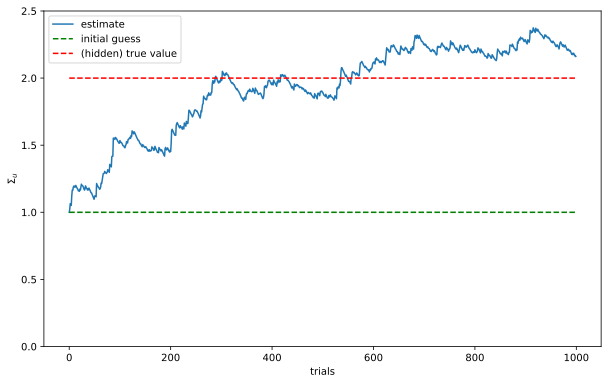

In [7]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.plot(var_u_, label='estimate')
ax.plot(var_u_init*np.ones_like(var_u_), 'g--', label='initial guess')
ax.plot(var_u*np.ones_like(var_u_), 'r--', label='(hidden) true value')
ax.set_ylim(0, 2.5)
ax.set_xlabel('trials')
ax.set_ylabel(r'$\Sigma_u$');
ax.legend()
if do_save: fig.savefig('../figures/bogacz_3.png', dpi=600)